In [2]:
#Instalar a biblioteca pandas
import pandas as pd
df = pd.read_csv("olist_analise_tratada.csv")

df.head(10)

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,tempo_entrega_dias,compras_por_pedido,customer_unique_id,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,1.0,7c396fd4830fd04220f754e42b4e5bff,...,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,1.0,7c396fd4830fd04220f754e42b4e5bff,...,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0,1.0,7c396fd4830fd04220f754e42b4e5bff,...,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4.0,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.0,1.0,af07308b275d755c9edb36a90c618231,...,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4.0,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.0,1.0,3a653a41f6f9fc3d2a113cf8398680e8,...,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5.0,NaN,NaN,2018-08-18 00:00:00,2018-08-22 19:07:58
5,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.0,1.0,7c142cf63193a1473d2e66489a9ae977,...,1.0,credit_card,1.0,72.20,359d03e676b3c069f62cadba8dd3f6e8,5.0,NaN,O produto foi exatamente o que eu esperava e e...,2017-12-03 00:00:00,2017-12-05 19:21:58
6,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.0,1.0,72632f0f9dd73dfee390c9b22eb56dd6,...,1.0,credit_card,1.0,28.62,e50934924e227544ba8246aeb3770dd4,5.0,NaN,NaN,2018-02-17 00:00:00,2018-02-18 13:02:51
7,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,16.0,1.0,80bb27c7c16e8f973207a5086ab329e2,...,1.0,credit_card,6.0,175.26,89b738e70a1ce346db29a20fb2910161,4.0,NaN,NaN,2017-07-27 00:00:00,2017-07-27 22:48:30
8,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09,NaN,1.0,36edbb3fb164b1f16485364b6fb04c73,...,1.0,credit_card,1.0,65.95,e07549ef5311abcc92ba1784b093fb56,2.0,NaN,fiquei triste por n ter me atendido.,2017-05-13 00:00:00,2017-05-13 20:25:42
9,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,9.0,1.0,932afa1e708222e5821dac9cd5db4cae,...,1.0,credit_card,3.0,75.16,07d67dd06ed5f88bef11ef6b464e79ae,5.0,NaN,NaN,2017-05-27 00:00:00,2017-05-28 02:59:57


In [3]:
display(df.info())

df = df.dropna()

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119143 non-null  object 
 1   customer_id                    119143 non-null  object 
 2   order_purchase_timestamp       119143 non-null  object 
 3   order_approved_at              118966 non-null  object 
 4   order_delivered_carrier_date   117057 non-null  object 
 5   order_delivered_customer_date  115722 non-null  object 
 6   order_estimated_delivery_date  119143 non-null  object 
 7   tempo_entrega_dias             115722 non-null  float64
 8   compras_por_pedido             118310 non-null  float64
 9   customer_unique_id             119143 non-null  object 
 10  customer_zip_code_prefix       119143 non-null  int64  
 11  customer_city                  119143 non-null  object 
 12  customer_state                

None

<class 'pandas.core.frame.DataFrame'>
Index: 11586 entries, 3 to 119124
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       11586 non-null  object 
 1   customer_id                    11586 non-null  object 
 2   order_purchase_timestamp       11586 non-null  object 
 3   order_approved_at              11586 non-null  object 
 4   order_delivered_carrier_date   11586 non-null  object 
 5   order_delivered_customer_date  11586 non-null  object 
 6   order_estimated_delivery_date  11586 non-null  object 
 7   tempo_entrega_dias             11586 non-null  float64
 8   compras_por_pedido             11586 non-null  float64
 9   customer_unique_id             11586 non-null  object 
 10  customer_zip_code_prefix       11586 non-null  int64  
 11  customer_city                  11586 non-null  object 
 12  customer_state                 11586 non-null  obj

None

In [4]:
df.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'tempo_entrega_dias', 'compras_por_pedido', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'review_id',
       'review_score', 'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp'],
      dtype='object')

In [5]:

Colunas = {
        "order_purchase_timestamp": "data_compra",
        "tempo_entrega_dias": "dias_entrega",
        "price": "preco_produto",
        "payment_type": "tipo_pagamento",
        "payment_value": "valor_pagamento",
        "review_score": "nota_avaliacao",
        "product_category_name": "categoria_produto",
        "customer_state":"estado_cliente"}

df.rename(columns=Colunas, inplace=True)
colunas_uteis = [
    "order_id",
    "categoria_produto",
    "tipo_pagamento",
    "valor_pagamento",
    "preco_produto",
    "nota_avaliacao",
    "data_compra",
    "estado_cliente"
]

df = df[colunas_uteis].copy()
df.columns

Index(['order_id', 'categoria_produto', 'tipo_pagamento', 'valor_pagamento',
       'preco_produto', 'nota_avaliacao', 'data_compra', 'estado_cliente'],
      dtype='object')

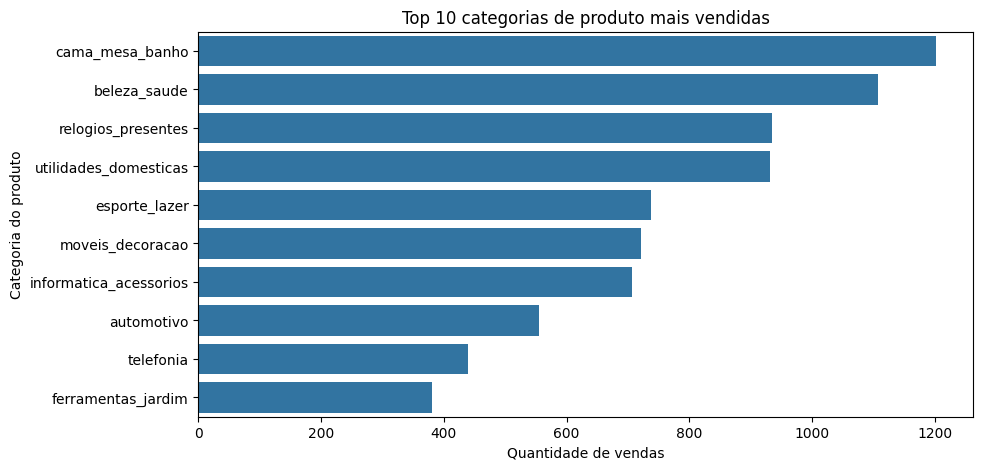

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

top_categorias = (
    df['categoria_produto']
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(x=top_categorias.values, y=top_categorias.index)
plt.title("Top 10 categorias de produto mais vendidas")
plt.xlabel("Quantidade de vendas")
plt.ylabel("Categoria do produto")
plt.show()


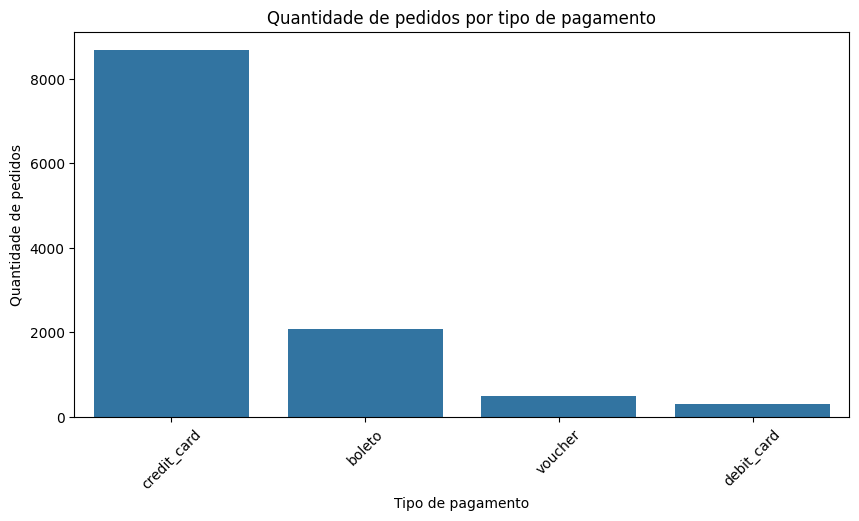

In [7]:

# Contagem dos tipos de pagamento
pagamentos = (
    df['tipo_pagamento']
    .value_counts()
    .reset_index()
)
pagamentos.columns = ['tipo_pagamento', 'quantidade']

Traduzir_pagamento = {
    'credit_card': 'Cartão de crédito',
    'boleto': 'Boleto',
    'voucher': 'Cupom',
    'debit_card': 'Cartão de Debito'
}
df['tipo_pagamento'] = df['tipo_pagamento'].replace(Traduzir_pagamento)

# Plot
plt.figure(figsize=(10,5))
sns.barplot(
    data=pagamentos,
    x='tipo_pagamento',
    y='quantidade'
)

plt.title("Quantidade de pedidos por tipo de pagamento")
plt.xlabel("Tipo de pagamento")
plt.ylabel("Quantidade de pedidos")
plt.xticks(rotation=45)
plt.show()

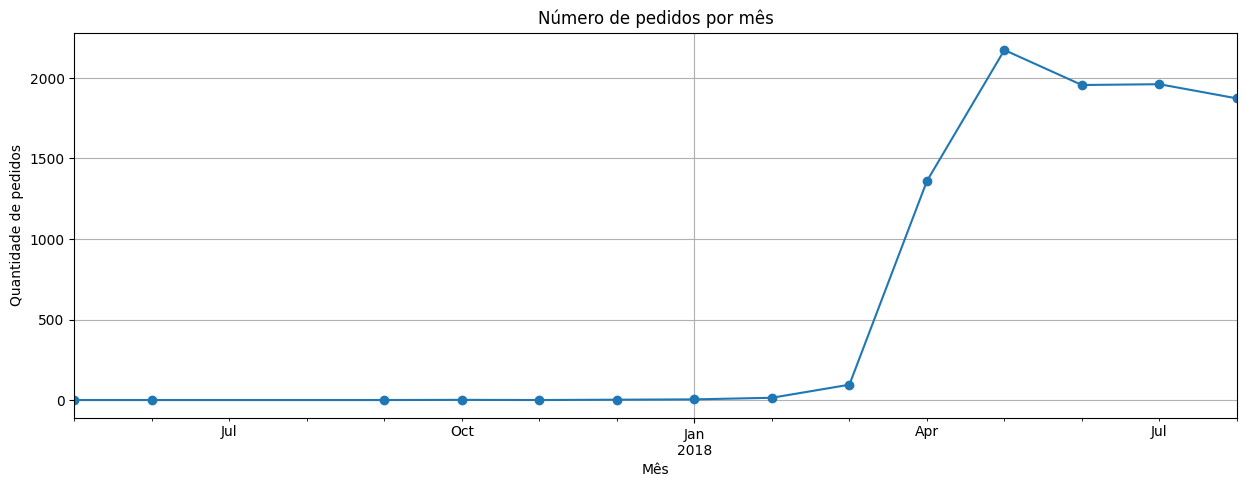

In [8]:
df['data_compra'] = pd.to_datetime(df['data_compra'], errors='coerce')
df['mes'] = df['data_compra'].dt.to_period('M')

pedidos_mes = (
    df.groupby('mes')['order_id']
    .nunique()
)

plt.figure(figsize=(15,5))
pedidos_mes.plot(kind='line', marker='o')
plt.title("Número de pedidos por mês")
plt.xlabel("Mês")
plt.ylabel("Quantidade de pedidos")
plt.grid(True)
plt.show()


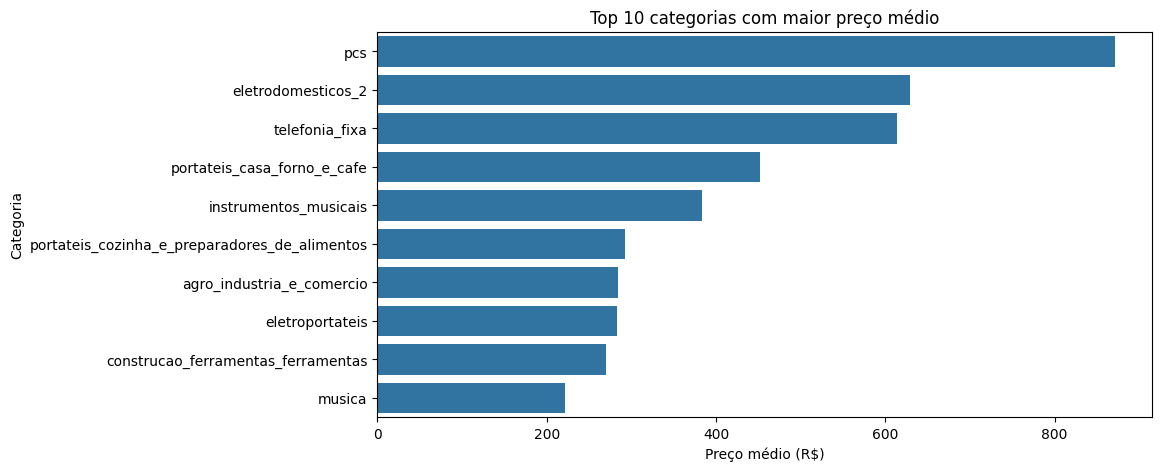

In [9]:
preco_categoria = (
    df.groupby("categoria_produto")["preco_produto"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
sns.barplot(x=preco_categoria.values, y=preco_categoria.index)
plt.title("Top 10 categorias com maior preço médio")
plt.xlabel("Preço médio (R$)")
plt.ylabel("Categoria")
plt.show()


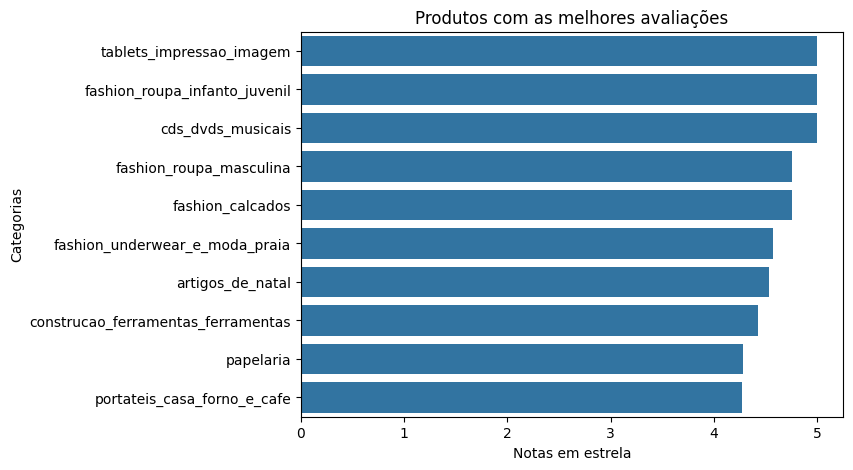

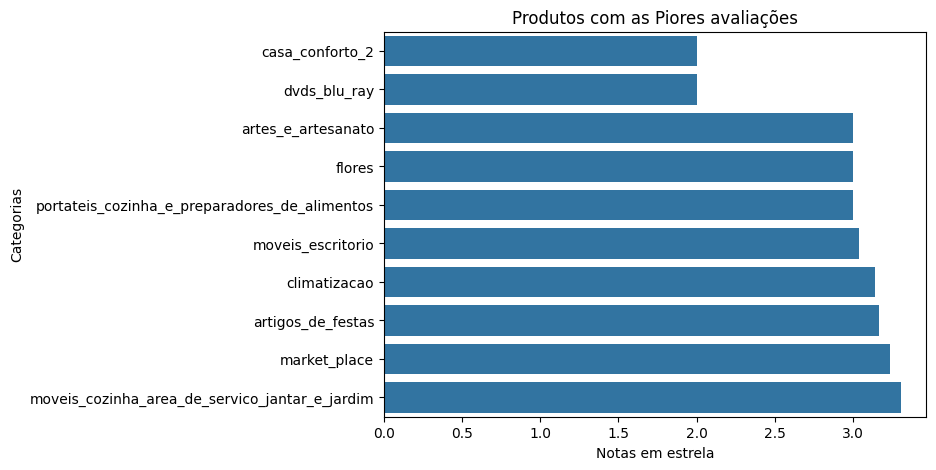

In [10]:
Avaliacao_categorias = (
    df.groupby("categoria_produto")["nota_avaliacao"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(7,5))
sns.barplot(x=Avaliacao_categorias.values, y=Avaliacao_categorias.index)
plt.title("Produtos com as melhores avaliações")
plt.xlabel("Notas em estrela")
plt.ylabel("Categorias")
plt.show()

Avaliacao_categorias = (
    df.groupby("categoria_produto")["nota_avaliacao"]
    .mean()
    .sort_values(ascending=True)
    .head(10)
)
plt.figure(figsize=(7,5))
sns.barplot(x=Avaliacao_categorias.values, y=Avaliacao_categorias.index)
plt.title("Produtos com as Piores avaliações")
plt.xlabel("Notas em estrela")
plt.ylabel("Categorias")
plt.show()

In [11]:


# Agrupar quantidade de compras por estado
compras_estado = (
    df.groupby("estado_cliente")["order_id"]
    .nunique()
    .reset_index()
    .rename(columns={"order_id": "total_compras"})
)

# Arquivo GeoJSON com mapas dos estados brasileiros
# Este arquivo funciona automaticamente com UF
geojson_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"

# Criar mapa
fig = px.choropleth(
    compras_estado,
    geojson=geojson_url,
    locations="estado_cliente",      # Coluna do DF com UF
    featureidkey="properties.sigla", # Nome da propriedade dentro do GeoJSON
    color="total_compras",
    color_continuous_scale="Viridis",
    title="Total de compras por estado (Olist)",
    labels={"total_compras": "Quantidade de Compras"},
)

fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(height=400)
df.to_csv("olist_tratada.csv", index=False, encoding="utf-8")
fig.show()
